<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/08_Abattoirs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [4]:
# import the oris and datas
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

In [5]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [6]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

# Add Abattoir East

In [7]:
AE_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_East_pts_elevation.shp"))
AE_pts = pd.DataFrame({'X': AE_pts.geometry.x, 
              'Y': AE_pts.geometry.y, 
              'Z': AE_pts.DEM_main})

AE_pts['fault_name'] = "Abattoir East Fault"

In [8]:
AE_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_East_Fault.shp"))

AE_seismic = AE_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AE_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AE_seismic['fault_name'] = AE_seismic['fault_name'].str.replace('Abattoir', "Abattoir East Fault")

In [9]:
gs = []

tmpA = []
tmpB = []

xs = AE_seismic['X'].to_numpy()
ys = AE_seismic['Y'].to_numpy()
zs = AE_seismic['Z'].to_numpy()

meanX = AE_pts['X'].mean()
meanY = AE_pts['Y'].mean()
meanZ = zs.max() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir East Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [10]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [11]:
updated_data = pd.concat([updated_data, AE_seismic, AE_pts])

In [12]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [13]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

# model.nsteps = [200, 200, 350]

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
                           #regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw = 0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])
model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cwp = 0.2)
# Force the tangents on BL Fault

tang2 = np.tile([2431.71, 36451.08, 15220.73],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0], 1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 18                     geological features that need to be interpolated



  0%|          | 0/18 [00:00<?, ?it/s]

Model update took: 100.09701371192932 seconds


In [14]:
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])

model['Zuleika Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])

model['Abattoir East Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Abattoir East Fault'].add_abutting_fault(model['Zuleika Fault'])


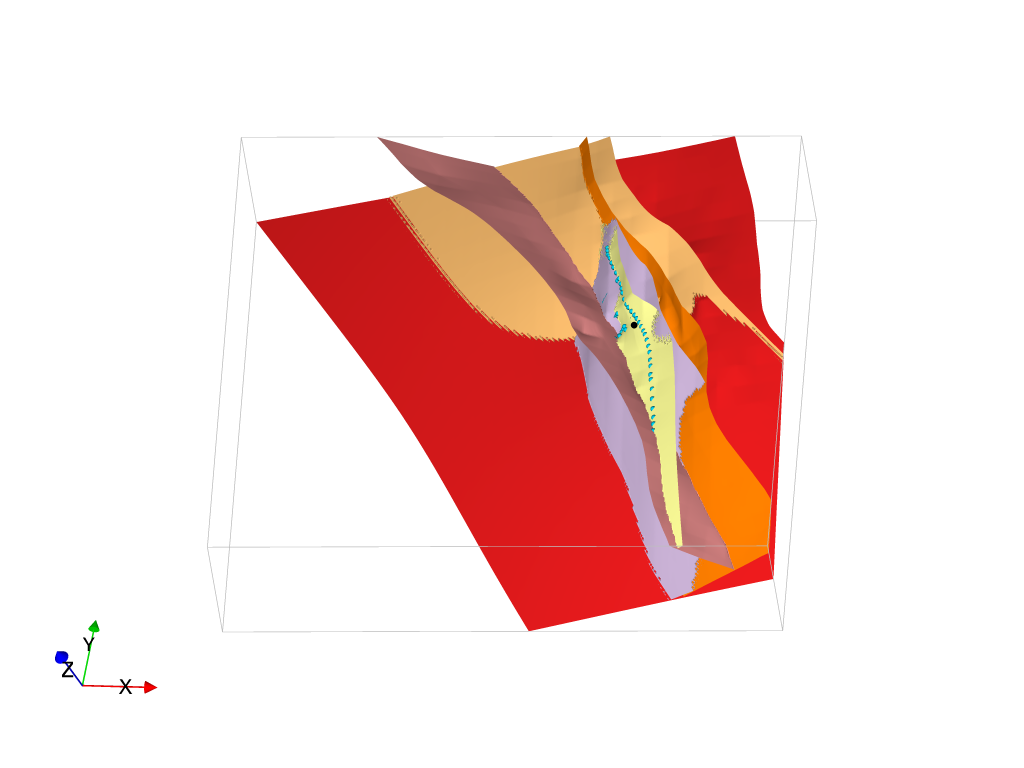

In [15]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Abattoir East Fault'], colours = ['#ffff99'], value = 0)

view.add_data(model['Abattoir East Fault'][0], pointsize = 5)

# view.interactive()

view.rotation = [-34.80955505371094, -7.021170139312744, 0.13161294162273407]
view.display()

# Abattoir West

In [16]:
AW_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_West_pts_elevation.shp"))
AW_pts = pd.DataFrame({'X': AW_pts.geometry.x, 
              'Y': AW_pts.geometry.y, 
              'Z': AW_pts.DEM_main})

AW_pts['fault_name'] = "Abattoir West Fault"

In [17]:
AW_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_West_Fault.shp"))

AW_seismic = AW_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AW_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AW_seismic['fault_name'] = AW_seismic['fault_name'].str.replace('unnamed02', "Abattoir West Fault")

In [18]:
gs = []

tmpA = []
tmpB = []

xs = AW_seismic['X'].to_numpy()
ys = AW_seismic['Y'].to_numpy()
zs = AW_seismic['Z'].to_numpy()

meanX = AW_pts['X'].mean()
meanY = AW_pts['Y'].mean()
meanZ = zs.max() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir West Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [19]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])

In [20]:
updated_data = pd.concat([updated_data, AW_seismic, AW_pts])

In [21]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [22]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data
# model.nsteps = [100, 200, 50]

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
#                            regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)

tang2 = np.tile([2431.71, 36451.08, 15220.73],
                (model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0], 1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 21                     geological features that need to be interpolated



  0%|          | 0/21 [00:00<?, ?it/s]

Model update took: 130.1377351284027 seconds


In [23]:
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])

model['Zuleika Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])

model['Abattoir East Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Abattoir East Fault'].add_abutting_fault(model['Zuleika Fault'])

model['Abattoir West Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Abattoir West Fault'].add_abutting_fault(model['Zuleika Fault'])


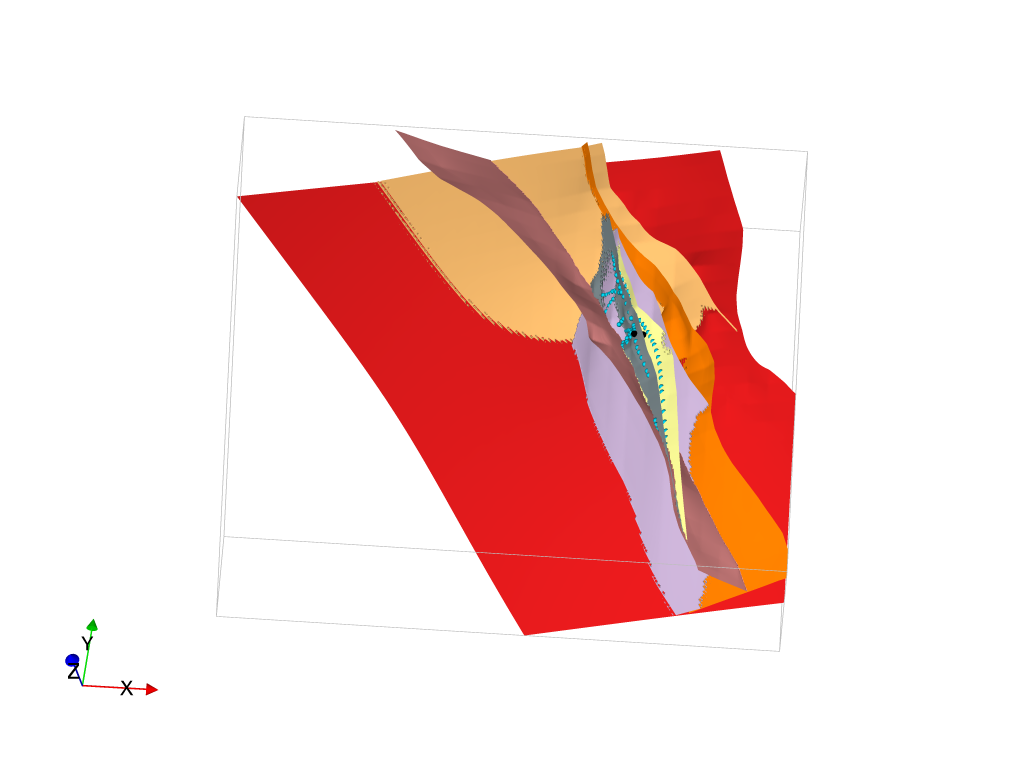

In [24]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Abattoir East Fault'], colours = ['#ffff99'], value = 0)
view.add_isosurface(model['Abattoir West Fault'], colours = ['#7d8b8f'], value = 0)

view.add_data(model['Abattoir West Fault'][0], pointsize = 5)
view.add_data(model['Abattoir East Fault'][0], pointsize = 5)

# view.interactive()
view.zmax = 0.95
view.rotation = [-32.61897277832031, 1.1916496753692627, -3.558317184448242]
view.display()

# Add it all up together

In [25]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data
# model.nsteps = [100, 200, 50]

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
#                            regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)


tang2 = np.tile([2431.71, 36451.08, 15220.73],
                (model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0], 1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

#force the tangents over the fault trace points
tang1 = np.tile([-68993.39,  -6446.72,  37268.88],
                (model['Ida Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Ida Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Ida Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Kunanalling Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Kunanalling Fault'].add_abutting_fault(model['Boorara Fault'])

model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kanowna Fault'])

model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault']) 
model['Zuleika Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])

model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])

model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])

model['Abattoir East Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Abattoir East Fault'].add_abutting_fault(model['Zuleika Fault'])

model['Abattoir West Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Abattoir West Fault'].add_abutting_fault(model['Zuleika Fault'])


model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 39                     geological features that need to be interpolated



  0%|          | 0/39 [00:00<?, ?it/s]

Model update took: 138.51402139663696 seconds



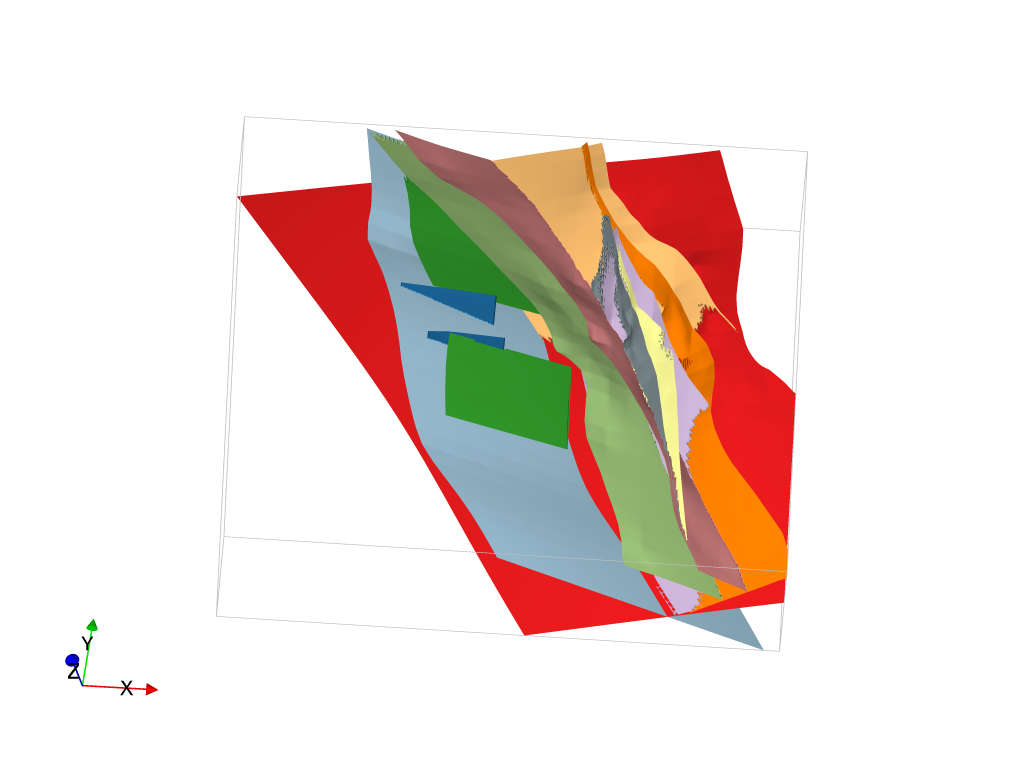

In [26]:
view = LavaVuModelViewer(model)

view.nelements = 5e6

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)

view.add_isosurface(model['Abattoir East Fault'], colours = ['#ffff99'], value = 0)
view.add_isosurface(model['Abattoir West Fault'], colours = ['#7d8b8f'], value = 0)

# view.interactive()
view.zmax = 0.95
view.rotation = [-32.61897277832031, 1.1916496753692627, -3.558317184448242]
view.display()

In [28]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)